In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import sys
sys.path.append('../../learnMSA')
from learnMSA import msa_hmm
import numpy as np
import tensorflow as tf
from BilinearSymmetric import SymmetricBilinearReduction
sys.path.append('..')
from src import Util

## Use static residual-level embeddings to enhance the quality of MSAs

Use pretraining $R \in \mathbb{R}^{d \times k}$ and scalar $b$ to compute emission probabilities for an input embedding $x$ and a match state $m$:

$$P(x \mid m) = \sigma(x R m + b).$$

Note that the match kernel $m$ has reduced dimension $k$. 

So far we found that for some protein families, this greatly increases MSA accuracy if the training data for $R$ and $b$ contains sequence sufficiently similar to the aligned sequences. We trained pretrained $R$ and $b$ on Pfam but did not clean any onverlap to the benchmark dataset Homfam yet.

We found that alignment quality with this approach greatly depends on regularization. We introduce $L2$ regularization of the embedding emission kernels as an easy way to prevent overfitting. For that we add a regularization term to the loss. Let $M_j$ and $I_j$ be $k$-dimensional embedding kernels for all match states and insertions. For simplicity we shared an insertion kernel $I$ between all positions so $I_j = I$ for all $j$. This makes $(L+1)*k$ parameters in total. In our experiments so far $k$ has been $64$. Let $m$ be the number of training sequences.

$$ \frac{1}{m} \lambda_M (\sum_j \sum_r M_{j,r}^2) + \lambda_I * L * \sum_r I_r^2 $$

The results are quite sensitive to the choices of $\lambda_M$ and $\lambda_I$.

We also found that (unlike with default learnMSA) making the insertion kernel $I$ trainable is a strict requirement for success. With frozen insertions learnMSA tends to produce long, uninformative alignments where most resiudes map to insertion states. Experiments with non-shared insertions for embedding emissions have not been successful so far.

We initialize the embedding kernels with zeros which means that the initial emission probabilities are solely defined by the bias $b$ which in pratice is a negative number meaning all emission probabilities are initially close to zero. As an alternative we experimented with an average embedding generated from the embedding training data for initialization, but found no obvious benefit over just using zeros. 

In the default configuration $R$ and $b$ are pretrained and fixed. We have ongoing experiments with making $b$ trainable to allow for a protein family specific control of the baseline emission probabilities. 

Making the insertions non-shared trainable leads to alignments with very low specificity. A useful feature could be a parameter matrix that is independent of the states that maps a small dimensional emission kernel to a larger one.

In [2]:
def masked_crossentropy(y_true, y_pred):
    mask = tf.reduce_any(tf.not_equal(y_true, 0), -1)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)
    cee = tf.keras.metrics.categorical_crossentropy(y_true_masked, y_pred_masked)
    return tf.reduce_mean(cee)
    
emb_dim = 2560
    
def make_model(reduced_dim = 256, dropout = 0.2):
    # input to the training pipeline are pairs of embeddings
    emb1 = tf.keras.layers.Input(shape=(None, emb_dim))
    emb2 = tf.keras.layers.Input(shape=(None, emb_dim))

    # outputs are homology probabilities 
    output = SymmetricBilinearReduction(reduced_dim,
                                        dropout, 
                                        use_attention_scores = True)(emb1, emb2)

    # construct a model and compile for a standard binary classification task
    model = tf.keras.models.Model(inputs=[emb1, emb2], outputs=output)

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-2,
        decay_steps=1000,
        decay_rate=0.9)

    model.compile(loss=masked_crossentropy, 
                  optimizer=tf.keras.optimizers.Adam(lr_schedule),
                  metrics=[tf.keras.metrics.CategoricalAccuracy()])
    
    return model

def get_bilinear_symmetric_layer():
    bilinear_symmetric_model = make_model(64, 0.2)
    bilinear_symmetric_model.load_weights("esm/bilinear_form_model_pfam_attention/checkpoints").expect_partial()
    bilinear_symmetric_layer = bilinear_symmetric_model.layers[-1]
    bilinear_symmetric_layer.trainable = False
    return bilinear_symmetric_layer

## Setup a data generator

In [3]:
prot_lm = "esm"

class EmbeddingBatchGenerator(msa_hmm.train.DefaultBatchGenerator):
    """ Computes batches of input sequences along with static embeddings.
        cache_embeddings: If true, all embeddings will be loaded once when configuring the generator and kept in memory. Otherwise they are loaded on the fly.
    """
    def __init__(self, cache_embeddings=True, shuffle=True):
        super().__init__(shuffle=shuffle)
        self.cache_embeddings = cache_embeddings
        if self.cache_embeddings:
            self.embedding_cache = []
        
    def _load_seq_embedding(self, seqid):
        return np.load(self.embeddings_base_path+f"{seqid}.npy")
        
    def configure(self, fasta_file, config):
        super().configure(fasta_file, config)
        noext_path = os.path.splitext(fasta_file.filename)[0]
        self.file_basename_noext = os.path.basename(noext_path)
        dataset = os.path.basename(os.path.dirname(os.path.dirname(noext_path)))
        self.embeddings_base_path = f"{prot_lm}/{dataset}/{self.file_basename_noext}/"
        bilinear_symmetric_layer = get_bilinear_symmetric_layer()
        if self.cache_embeddings:
            if len(self.embedding_cache) == 0:
                #print("Precomputing reduced embeddings.")
                for i, seq_id in enumerate(fasta_file.seq_ids):
                    emb = self._load_seq_embedding(seq_id)
                    #compute emission probs for all positions including padding
                    reduced_emb = bilinear_symmetric_layer._reduce(emb, training=False) 
                    self.embedding_cache.append(reduced_emb)
                    #for p in np.linspace(0.1,0.9,9)[::-1]:
                        #if i > 0 and float(i)/fasta_file.num_seq >= p and float(i-1)/fasta_file.num_seq < p:
                            #print(f"{np.round(p*100)}% done")
                
    def _pad_embeddings(self, embeddings):
        """ Packs a list of lists of embeddings where each embedding is a 2D tensor into a padded 4D tensor.
            The padding will be zero for all embedding dimensions and one in a new dimension added at the end (the terminal dimension).
        """
        num_models = len(embeddings)
        batch_size = len(embeddings[0])
        max_len = max([emb.shape[0] for model_batch in embeddings for emb in model_batch])
        dim = embeddings[0][0].shape[1]
        padded_embeddings = np.zeros((num_models, batch_size, max_len+1, dim+1), dtype=np.float32)
        for i,model_batch in enumerate(embeddings):
            for j,emb in enumerate(model_batch):
                l = emb.shape[0]
                padded_embeddings[i,j,:l,:-1] = emb
                padded_embeddings[i,j,l:,-1] = 1 #terminal dimension
        return padded_embeddings
        
    def __call__(self, indices):
        batch, batch_indices = super().__call__(indices)
        #retrieve the embeddings for all models and sequences in list-of-lists format
        embeddings = []
        for ind in batch_indices:
            embeddings.append([])
            for i in ind:
                if self.cache_embeddings:
                    embeddings[-1].append(self.embedding_cache[i])
                else: #load the embeddings dynamically
                    seq_id = self.fasta_file.seq_ids[i]
                    embeddings[-1].append(self._load_seq_embedding(seq_id))
        #put them in a tensor with padding
        padded_embeddings = self._pad_embeddings(embeddings)
        return batch, batch_indices, padded_embeddings
    
    def get_out_types(self):
        if self.return_only_sequences:
            return (tf.uint8)
        else:
            return (tf.uint8, tf.int64, tf.float32)  

In [4]:
#test the embeddings batch generator
bg = EmbeddingBatchGenerator()
config = msa_hmm.config.make_default()
fasta_file = msa_hmm.fasta.Fasta("../data/homfam/train/egf.fasta")
bg.configure(fasta_file, config)
batch, batch_indices, padded_embeddings = bg(np.array([0, 1]))
bilinear_symmetric_layer = get_bilinear_symmetric_layer()
for i,model_batch in enumerate(batch_indices):
    for j,seq_index in enumerate(model_batch):
        length = fasta_file.seq_lens[seq_index]
        assert np.all(batch[i,j,:length] == fasta_file.get_raw_seq(seq_index))
        assert np.all(batch[i,j,length:] == 25)
        seq_id = fasta_file.seq_ids[seq_index]
        ref_emb = np.load(f"esm/homfam/egf/{seq_id}.npy")
        assert np.all(bilinear_symmetric_layer._reduce(ref_emb, training=False) == padded_embeddings[i,j,:length,:-1])
        assert np.all(padded_embeddings[i,j,:length,-1] == 0)
        assert np.all(padded_embeddings[i,j,length:,-1] == 1)
        assert np.all(padded_embeddings[i,j,length:,:-1] == 0)

In [5]:
batch, batch_indices, padded_embeddings = bg(np.array([0,1,2]))
batch.shape, batch_indices.shape, padded_embeddings.shape

((3, 5, 39), (3, 5), (3, 5, 39, 65))

In [6]:
embedding_dim = bg(np.array([0]))[2].shape[-1]

In [7]:
del bg

In [8]:
embedding_dim

65

## Setup the model

In [9]:
global_emb = np.zeros((embedding_dim-1), dtype=np.float32)

class L2EmbeddingRegularizer(msa_hmm.priors.AminoAcidPrior):
    """ A simple L2 regularizer for the embedding match states
    """
    def __init__(self, 
                 L2_match, 
                 L2_insert,
                 use_shared_embedding_insertions):
        super().__init__()
        self.L2_match = L2_match
        self.L2_insert = L2_insert
        self.use_shared_embedding_insertions = use_shared_embedding_insertions
        
    def get_reg(self, B, lengths):
        max_model_length = tf.reduce_max(lengths)
        length_mask = tf.cast(tf.sequence_mask(lengths), B.dtype)
        #square all parameters
        B_emb_sq = tf.math.square(B[...,25:-1])
        #reduce the embedding dimension
        B_emb_sq = tf.reduce_sum(B_emb_sq, -1)
        #regularization per match is just the sum of the respective squares 
        #(we will deal with non-match states in the end)
        reg_emb = B_emb_sq[:,1:max_model_length+1]
        #depending on how we implemented insertions, we add a different insertion term to all matches
        if self.use_shared_embedding_insertions:
            #all insertions are the same, just use the first one 
            reg_ins = B_emb_sq[:,:1]
        else:
            #insertions differ, use their average
            B_emb_sq_just_matches = reg_emb * length_mask
            B_emb_sq_just_inserts = tf.reduce_sum(B_emb_sq, axis=1, keepdims=True) - tf.reduce_sum(B_emb_sq_just_matches, axis=1, keepdims=True)
            reg_ins = B_emb_sq_just_inserts / tf.expand_dims(tf.cast(lengths, B.dtype), -1)
        reg = self.L2_match * reg_emb + self.L2_insert * reg_ins
        #zero padding for non match states
        reg *= length_mask
        return reg
        
    def __call__(self, B, lengths):
        """L2 regularization for each match state.
        Args:
        B: A stack of k emission matrices. Shape: (k, q, s)
        Returns:
        A tensor with the L2 regularization values. Shape: (k, max_model_length)
        """
        #amino acid prior
        B_amino = B[:,:,:25]
        prior_aa = super().__call__(B_amino, lengths)
        reg = self.get_reg(B, lengths)
        return prior_aa - reg #the result is maximized, so we have to negate the regularizer

In [10]:
# test the regularizer
reg_shared = L2EmbeddingRegularizer(1, 1, True)
reg_non_shared = L2EmbeddingRegularizer(1, 1, False)
reg_shared.load("float32")
reg_non_shared.load("float32")
#just test the embedding part
lengths = [5, 6]
B = np.zeros((2, 20, 101), dtype=np.float32)
B[0, :2*lengths[0]+2, 25:] = 2.
B[0, 1:lengths[0]+1, 25:] = 3.
B[1, :2*lengths[1]+2, 25:] = 5.
B[1, 1:lengths[1]+1, 25:] = 4.
r1 = reg_shared.get_reg(B, lengths)
r2 = reg_non_shared.get_reg(B, lengths)
assert all(r1[0,:-1] == 75 * 9 + 75 * 4)
assert r1[0,-1] == 0
assert all(r1[1,:-1] == 75 * 16 + 75 * 25)
assert all(r2[0,:-1] == 75 * 9 + 7 * 75 * 4 / 5)
assert r2[0,-1] == 0
assert all(r2[1,:-1] == 75 * 16 + 8 * 75 * 25 / 6)

In [11]:
#currently used
class EmbeddingEmissionInitializer(tf.keras.initializers.Initializer):
    """ Initializes the embedding distributions by assigning a AA background distribution to the first 25 positions
        and a precomputed global average embedding for the other positions.
    """

    def __init__(self,
                 aa_dist=np.log(msa_hmm.initializers.background_distribution), 
                 global_emb=global_emb):
        self.aa_dist = aa_dist
        self.global_emb = global_emb

    def __call__(self, shape, dtype=None, **kwargs):
        assert shape[-1] >= self.aa_dist.size
        aa_dist = tf.cast(self.aa_dist, dtype)
        global_emb = tf.cast(self.global_emb, dtype)
        aa_init = tf.reshape(tf.tile(aa_dist, tf.cast(tf.math.reduce_prod(shape[:-1], keepdims=True), tf.int32)), list(shape[:-1])+[self.aa_dist.size])
        emb_init = tf.reshape(tf.tile(global_emb, tf.cast(tf.math.reduce_prod(shape[:-1], keepdims=True), tf.int32)), list(shape[:-1])+[shape[-1]-self.aa_dist.size])
        return tf.concat([aa_init, emb_init], axis=-1)
    
    def __repr__(self):
        return f"EmbeddingEmissionInitializer()"

In [12]:
#have a single emitter that handles both AA inputs and embeddings
#need a proper implementation of a RNN with nested inputs later
class EmbeddingEmitter(msa_hmm.emit.ProfileHMMEmitter):
    def __init__(self, 
                 L2_match,
                 L2_insert,
                 emission_init=EmbeddingEmissionInitializer(), 
                 insertion_init=EmbeddingEmissionInitializer(),
                 use_shared_embedding_insertions=True,
                 frozen_insertions=True):
        super(EmbeddingEmitter, self).__init__(emission_init, 
                                               insertion_init,
                                               L2EmbeddingRegularizer(L2_match, L2_insert, use_shared_embedding_insertions), 
                                               frozen_insertions=frozen_insertions)
        self.L2_match = L2_match
        self.L2_insert = L2_insert
        self.use_shared_embedding_insertions = use_shared_embedding_insertions
        self.bilinear_symmetric_layer = get_bilinear_symmetric_layer()
        
    def build(self, input_shape):
        s = 25 + self.bilinear_symmetric_layer.reduced_dim
        if self.use_shared_embedding_insertions:
            #the default emitter would construct an emission matrix matching the last input dimension
            #in this case the last input dimension is the full embedding depth whereas the emission matrix
            #should be constructed for the reduced dim as defined in the bilinear symmetric layer
            shape = (input_shape[0], s + 1)
            super().build(shape)
        else:
            #todo: this is a hacky solutions
            #do it clean by rewriting ProfileHMMEmitter
            self.emission_kernel = [self.add_weight(
                                            shape=[length, s], 
                                            initializer=init, 
                                            name="emission_kernel_"+str(i))
                                        for i,(length, init) in enumerate(zip(self.length, self.emission_init))]
            self.insertion_kernel = [ self.add_weight(
                                    shape=[25],
                                    initializer=init,
                                    name="insertion_kernel_"+str(i),
                                    trainable=not self.frozen_insertions) 
                                        for i,init in enumerate(self.insertion_init)]
            self.embedding_insertion_kernel = [self.add_weight(
                                            shape=[length+2, self.bilinear_symmetric_layer.reduced_dim], 
                                            initializer="zeros", 
                                            name="embedding_emission_kernel_"+str(i),
                                            trainable=not self.frozen_insertions)
                                        for i,length in enumerate(self.length)]
        self.temperature = self.add_weight(shape=(len(self.emission_init)), initializer=tf.constant_initializer(0), name="temperature")
        self.built = True
            
        
    def call(self, inputs):
        """ 
        Args: 
            inputs: Shape (num_models, batch, seq_len, d) 
        Returns:
            Shape (num_models, batch, seq_len, num_states)
        """
        num_models, batch, seq_len, d  = tf.unstack(tf.shape(inputs))
        num_states = tf.shape(self.B_transposed)[-1]
        emit_shape = (num_models, batch, seq_len, num_states)
        terminal_padding = inputs[..., -1:]
        inputs = tf.reshape(inputs, (num_models, -1, d)) 
        
        #compute amino acid emissions
        aa_inputs = inputs[..., :26]
        aa_B_transposed = self.B_transposed[:,:26,:]
        aa_emission_probs = tf.matmul(aa_inputs, aa_B_transposed)
        aa_emission_probs = tf.reshape(aa_emission_probs, emit_shape)
        
        #compute embedding emission probs
        emb_inputs = inputs[..., 26:]
        emb_B = self.B[..., 26:]
        #embedding scores that sum to 1 over all valid input sequence positions
        emb_emission_probs = self.bilinear_symmetric_layer(emb_B[..., :-1], 
                                                           emb_inputs[..., :-1], 
                                                           a_is_reduced=True, 
                                                           b_is_reduced=True, 
                                                           training=False, 
                                                           activate_output=False) 
        emb_emission_probs = tf.transpose(emb_emission_probs, [0, 2, 1])
        emb_emission_probs = tf.reshape(emb_emission_probs, emit_shape) # (k, b*l, q) -> (k, b, l, q)
        emb_emission_probs = tf.nn.softmax(emb_emission_probs)
        emb_emission_probs = tf.math.pow(emb_emission_probs, tf.math.sigmoid(self.temperature[:, tf.newaxis, tf.newaxis, tf.newaxis]))
        #padding/terminal states
        emb_emission_probs *= 1-terminal_padding # set positions with softmax(0, ..., 0) to 0
        #set emission probs to 1 where sequence input is terminal and state is also terminal
        emb_emission_probs += terminal_padding * emb_B[:, tf.newaxis, tf.newaxis, :, -1]
        
        emission_probs = aa_emission_probs * emb_emission_probs
        return emission_probs
    
    def make_emission_matrix(self, i):
        aa_em = self.emission_kernel[i][:, :25]
        emb_em = self.emission_kernel[i][:, 25:]
        #drop the terminal state probs since we have identical ones for the embeddings
        aa_emissions = self.make_emission_matrix_from_kernels(aa_em, self.insertion_kernel[i][:25], self.length[i])
        """ Construct the emission matrix the same way as usual but leave away the softmax.
        """
        s = emb_em.shape[-1]
        if self.use_shared_embedding_insertions:
            emb_ins = self.insertion_kernel[i][25:]
            emb_em = tf.concat([tf.expand_dims(emb_ins, 0), 
                               emb_em, 
                               tf.stack([emb_ins]*(self.length[i]+1))] , axis=0)
        else:
            emb_em = tf.concat([self.embedding_insertion_kernel[i][:1], 
                               emb_em, 
                               self.embedding_insertion_kernel[i][1:]] , axis=0)
        emb_em = tf.concat([emb_em, tf.zeros_like(emb_em[:,:1])], axis=-1) 
        end_state_emission = tf.one_hot([s], s+1, dtype=emb_em.dtype) 
        emb_emissions = tf.concat([emb_em, end_state_emission], axis=0)
        return tf.concat([aa_emissions, emb_emissions], -1)
    
    def duplicate(self, model_indices=None):
        if model_indices is None:
            model_indices = range(len(self.emission_init))
        sub_emission_init = [tf.constant_initializer(self.emission_kernel[i].numpy()) for i in model_indices]
        sub_insertion_init = [tf.constant_initializer(self.insertion_kernel[i].numpy()) for i in model_indices]
        #todo: this does not dublicate embedding insertion kernels which is probably ok
        emitter_copy = EmbeddingEmitter(
                             L2_match = self.L2_match,
                             L2_insert = self.L2_insert,
                             emission_init = sub_emission_init,
                             insertion_init = sub_insertion_init,
                             use_shared_embedding_insertions=self.use_shared_embedding_insertions,
                             frozen_insertions=self.frozen_insertions) 
        return emitter_copy
        
    def make_B_amino(self):
        """ A variant of make_B used for plotting the HMM. Can be overridden for more complex emissions. Per default this is equivalent to make_B
        """
        return self.make_B()[:,:,:25]

In [13]:
def generic_embedding_model_generator(encoder_layers,
                                      msa_hmm_layer):
    """A generic model generator function. The model inputs are sequences of shape (b, num_model, L) 
        and sequence indices of shape (b, num_model).
    Args:
        encoder_layers: A list of layers with compatible inputs and outputs and the last output 
                        is compatible with msa_hmm_layer. 
        msa_hmm_layer: An instance of MsaHmmLayer.
    """
    num_models = msa_hmm_layer.cell.num_models
    sequences = tf.keras.Input(shape=(None,None), name="sequences", dtype=tf.uint8)
    indices = tf.keras.Input(shape=(None,), name="indices", dtype=tf.int64)
    embeddings = tf.keras.Input(shape=(None,None,embedding_dim), name="embeddings", dtype=tf.float32)
    #in the input pipeline, we need the batch dimension to come first to make multi GPU work 
    #we transpose here, because all learnMSA layers require the model dimension to come first
    transposed_sequences = tf.transpose(sequences, [1,0,2])
    transposed_indices = tf.transpose(indices)
    transposed_embeddings = tf.transpose(embeddings, [1,0,2,3])
    forward_seq = transposed_sequences
    for layer in encoder_layers:
        forward_seq = layer(forward_seq, transposed_indices)
    concat_seq = tf.concat([forward_seq, transposed_embeddings], -1)
    loglik = msa_hmm_layer(concat_seq)
    #transpose back to make model.predict work correctly
    loglik = tf.transpose(loglik)
    model = tf.keras.Model(inputs=[sequences, indices, embeddings], 
                        outputs=[tf.keras.layers.Lambda(lambda x: x, name="loglik")(loglik)])
    return model


def model_generator(num_seq,
                    effective_num_seq,
                    model_lengths, 
                    config,
                    fasta_file,
                    alphabet_size=25):
    """A callback that constructs the default learnMSA model.
    Args:
        num_seq: The total number of sequences to align.
        effective_num_seq: The actual number of sequences currently used for training (model surgery might use only a subset).
        model_lengths: List of pHMM lengths.
        config: Dictionary storing the configuration.
        fasta_file: A fasta_file. This is part of the model generator callback because the generated model might depends on data like maximum sequence length.
        alphabet_size: Number of symbols without the terminal symbol (i.e. 25 for amino acids).
    """
    num_models = config["num_models"]
    assert len(model_lengths) == num_models, \
        (f"The list of given model lengths ({len(model_lengths)}) should"
         + f" match the number of models specified in the configuration({num_models}).")
    msa_hmm_layer = msa_hmm.train.make_msa_hmm_layer(effective_num_seq, model_lengths, config, alphabet_size)
    anc_probs_layer = msa_hmm.train.make_anc_probs_layer(num_seq, config)
    model = generic_embedding_model_generator([anc_probs_layer], msa_hmm_layer)
    return model

## Train and align

In [15]:
def get_adaptive_batch_size(model_lengths, max_seq_len):
    model_length = max(model_lengths)
    if max_seq_len < 200 and model_length < 200:
        return 200
    elif max_seq_len < 520 and model_length < 290:
        return 100
    elif max_seq_len < 800 and model_length < 500:
        return 50
    else:
        return 25

In [23]:
train_filename = "../data/homfam/train/egf.fasta" 
ref_filename = "../data/homfam/refs/egf.ref"
out_filename = "interactive.alignment.fasta"

num_models = 10
config = dict(msa_hmm.config.make_default(num_models))
config["allow_user_keys_in_config"] = True
config["embedding_l2_match"] = 1
config["embedding_l2_insert"] = 0
config["len_mul"] = 0.8
config["use_shared_embedding_insertions"] = True
config["frozen_insertions"] = True
config["learning_rate"] = 0.05
emission_init = [EmbeddingEmissionInitializer() for _ in range(num_models)]
if config["use_shared_embedding_insertions"]:
    insertion_init = [EmbeddingEmissionInitializer() for _ in range(num_models)]
else:
    insertion_init = [msa_hmm.initializers.make_default_insertion_init() for _ in range(num_models)]
config["emitter"] = EmbeddingEmitter(config["embedding_l2_match"], 
                                     config["embedding_l2_insert"], 
                                     emission_init=emission_init, 
                                     insertion_init=insertion_init,
                                     use_shared_embedding_insertions=config["use_shared_embedding_insertions"],
                                     frozen_insertions=config["frozen_insertions"])
config["batch_size"] = get_adaptive_batch_size

alignment, r = msa_hmm.align.run_learnMSA(train_filename,
                                          out_filename,
                                          config, 
                                          model_generator=model_generator,
                                          batch_generator=EmbeddingBatchGenerator(),
                                          ref_filename=ref_filename, 
                                          verbose=True,
                                          select_best_for_comparison=False)

Training of 10 models on file egf.fasta
Configuration: 
{
num_models : 10
transitioner : ProfileHMMTransitioner(
 transition_init=
    {
    begin_to_match : DefaultEntry() , match_to_end : DefaultExit() , 
    match_to_match : DefaultMatchTransition(1) , match_to_insert : DefaultMatchTransition(-1) , 
    insert_to_match : Norm(0, 0.1) , insert_to_insert : Norm(-0.5, 0.1) , 
    match_to_delete : DefaultMatchTransition(-1) , delete_to_match : Norm(0, 0.1) , 
    delete_to_delete : Norm(-0.5, 0.1) , left_flank_loop : Norm(0, 0.1) , 
    left_flank_exit : Norm(-1, 0.1) , right_flank_loop : Norm(0, 0.1) , 
    right_flank_exit : Norm(-1, 0.1) , unannotated_segment_loop : Norm(0, 0.1) , 
    unannotated_segment_exit : Norm(-1, 0.1) , end_to_unannotated_segment : Norm(-9, 0.1) , 
    end_to_right_flank : Norm(0, 0.1) , end_to_terminal : Norm(0, 0.1)
    },
 flank_init=Const(0.0),
 prior=ProfileHMMTransitionPrior(match_comp=1, insert_comp=1, delete_comp=1, alpha_flank=7000, alpha_single=100

In [24]:
train_filename = "../data/homfam/train/msb.fasta" 
ref_filename = "../data/homfam/refs/msb.ref"
out_filename = "interactive.alignment.fasta"

num_models = 10
config = dict(msa_hmm.config.make_default(num_models))
config["allow_user_keys_in_config"] = True
config["embedding_l2_match"] = 1
config["embedding_l2_insert"] = 0
config["len_mul"] = 0.8
config["use_shared_embedding_insertions"] = True
config["frozen_insertions"] = True
config["learning_rate"] = 0.05
emission_init = [EmbeddingEmissionInitializer() for _ in range(num_models)]
if config["use_shared_embedding_insertions"]:
    insertion_init = [EmbeddingEmissionInitializer() for _ in range(num_models)]
else:
    insertion_init = [msa_hmm.initializers.make_default_insertion_init() for _ in range(num_models)]
config["emitter"] = EmbeddingEmitter(config["embedding_l2_match"], 
                                     config["embedding_l2_insert"], 
                                     emission_init=emission_init, 
                                     insertion_init=insertion_init,
                                     use_shared_embedding_insertions=config["use_shared_embedding_insertions"],
                                     frozen_insertions=config["frozen_insertions"])
#config["transitioner"] = msa_hmm.trans.ProfileHMMTransitioner([msa_hmm.initializers.make_default_transition_init(MM=2, DD=-1) 
#                                                                         for _ in range(num_models)],
#                                           [msa_hmm.initializers.make_default_flank_init()
#                                                                         for _ in range(num_models)])
config["batch_size"] = get_adaptive_batch_size

alignment, r = msa_hmm.align.run_learnMSA(train_filename,
                                          out_filename,
                                          config, 
                                          model_generator=model_generator,
                                          batch_generator=EmbeddingBatchGenerator(),
                                          ref_filename=ref_filename, 
                                          verbose=True,
                                          select_best_for_comparison=False)

Training of 10 models on file msb.fasta
Configuration: 
{
num_models : 10
transitioner : ProfileHMMTransitioner(
 transition_init=
    {
    begin_to_match : DefaultEntry() , match_to_end : DefaultExit() , 
    match_to_match : DefaultMatchTransition(1) , match_to_insert : DefaultMatchTransition(-1) , 
    insert_to_match : Norm(0, 0.1) , insert_to_insert : Norm(-0.5, 0.1) , 
    match_to_delete : DefaultMatchTransition(-1) , delete_to_match : Norm(0, 0.1) , 
    delete_to_delete : Norm(-0.5, 0.1) , left_flank_loop : Norm(0, 0.1) , 
    left_flank_exit : Norm(-1, 0.1) , right_flank_loop : Norm(0, 0.1) , 
    right_flank_exit : Norm(-1, 0.1) , unannotated_segment_loop : Norm(0, 0.1) , 
    unannotated_segment_exit : Norm(-1, 0.1) , end_to_unannotated_segment : Norm(-9, 0.1) , 
    end_to_right_flank : Norm(0, 0.1) , end_to_terminal : Norm(0, 0.1)
    },
 flank_init=Const(0.0),
 prior=ProfileHMMTransitionPrior(match_comp=1, insert_comp=1, delete_comp=1, alpha_flank=7000, alpha_single=100

In [25]:
t = alignment.model.layers[-3].cell.emitter[0].temperature
t, tf.math.sigmoid(t)

(<tf.Variable 'msa_hmm_layer/temperature:0' shape=(10,) dtype=float32, numpy=
 array([-5.213535 , -5.1831713, -5.184705 , -5.1768413, -5.197887 ,
        -5.180172 , -5.1783032, -5.1637177, -5.1848893, -5.158669 ],
       dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([0.00541294, 0.00557889, 0.00557039, 0.00561412, 0.00549784,
        0.00559555, 0.00560596, 0.00568786, 0.00556936, 0.00571648],
       dtype=float32)>)

>l=-258.66_t=0.01
.......................wsyntst$EAMTYDEASAYCQQR..YTHLVAIQNKEEIEYLNSILSYS.-.-PSYYWIGIRKV--..NNVWVWVgTQKPLTeEAKNWAPG...EPNNR-QKDEDCVEIYIKRekDVGMWNDERCSKKKLALCYT$a..
>l=-234.14_t=0.01
.......................kyfmssv$RRMPLNRAKALCSEL..QGTVATPRNAEENRAIQNVAK--.-.--DVAFLGITDQRT..ENVFEDL.TGNRV-.RYTNWNEG...EPNNV-GSGENCVVLLTN-..--GKWNDVPCSDSFLVVCEF$s..
>l=-252.25_t=0.03
....................sgkkffvtnh$ERMPFSKVKALCSEL..RGTVAIPRNAEENKAIQEVA---.-.-KTSAFLGITDEVT..EGQFMYV.TGGRL-.TYSNWKKD...EPNDH-GSGEDCVTIVDN-..--GLWNDISCQASHTAVCEF$pa.
>l=-316.33_t=0.15
.........alqtvclkgtkvhmkcflaft$QTKTFHEASEDCISR..GGTLSTPQTGSENDALYEYLRQSvG.NEAEIWLGLNDMAA..EGTWVDM.TGARI-.AYKNWETEitaQPD--GGKTENCAVLSGA-..ANGKWFDKRCRDQLPYICQF$giv
>l=-316.84_t=0.41
.......qragpncpagwqplgdrciyyet$TAMTWALAETNCMKL..GGHLASIHSQEEHSFIQTL----.-.NAGVVWIGGSACLQ..AGAWTWS.DGTPM-.NFRSWCST...KPDDV--LAACCMQMTAA-..ADQCWDDLPCPASHKSVCAM$tf.
>l=-328.46_t=0.01
qaaatelpaaaascpegtnayrsycyyfne$DRETWVDADLYCQNMn.SGNLVSVLTQAEGAFVASLIKES.GtDDFNVWIG

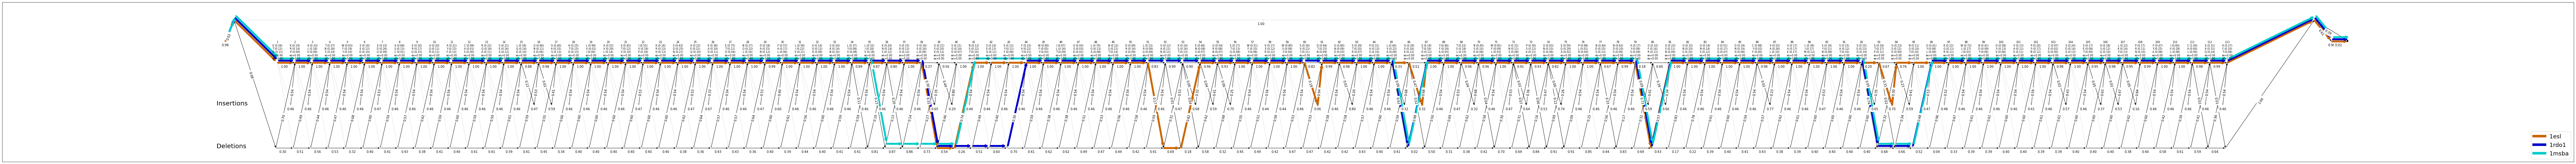

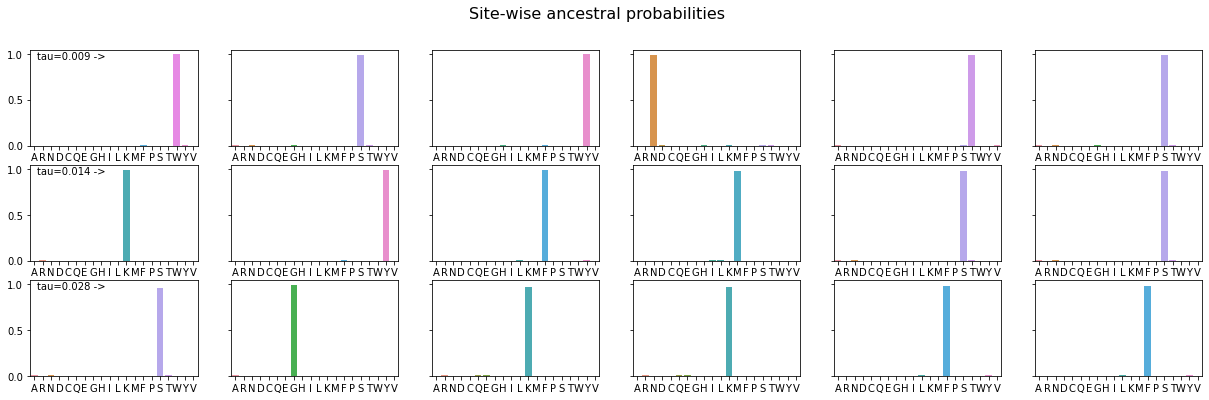

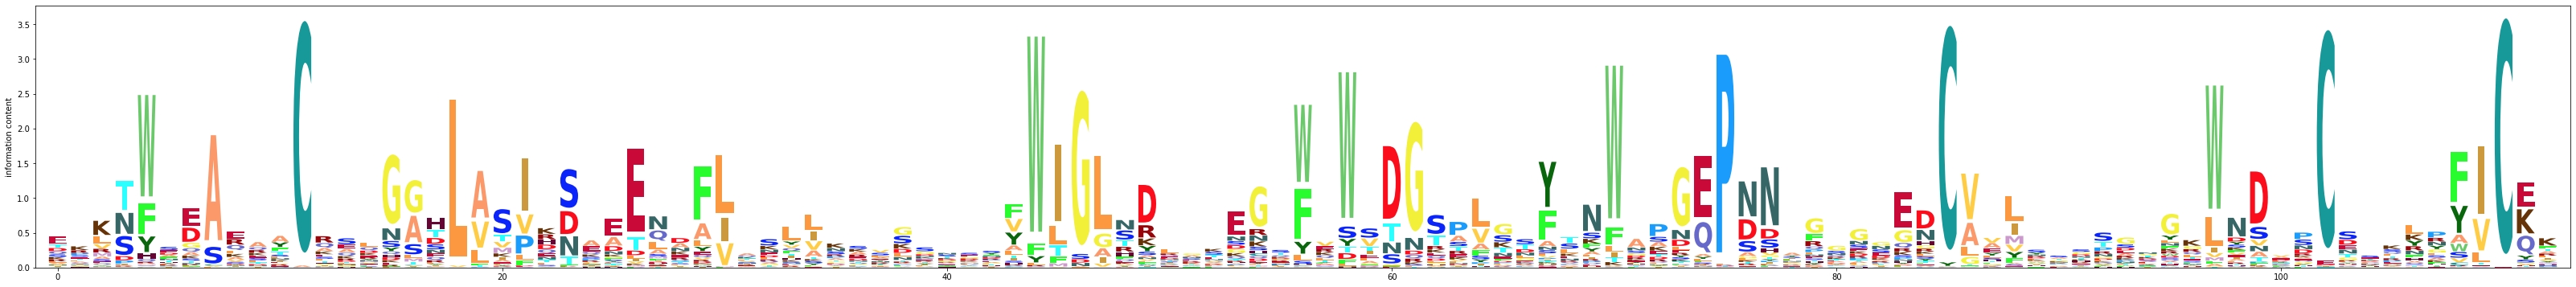

In [26]:
msa_hmm.vis.print_and_plot(alignment, alignment.best_model)

In [27]:
match_embeddings = alignment.model.layers[-3].cell.emitter[0].make_B()[..., 26:-1]
np.amin(match_embeddings), np.amax(match_embeddings)

(-1.3748833, 1.6844311)

In [28]:
#load embeddings
filename = "../data/homfam/refs/msb.ref" 
fasta_file = msa_hmm.fasta.Fasta(filename, aligned=True)
noext_path = os.path.splitext(fasta_file.filename)[0]
file_basename_noext = os.path.basename(noext_path)
dataset = os.path.basename(os.path.dirname(os.path.dirname(noext_path)))
embeddings_base_path = f"esm/homfam/{file_basename_noext}/"
embedding_cache = []
for i, seq_id in enumerate(fasta_file.seq_ids):
    emb = np.load(embeddings_base_path+f"{seq_id}.npy")
    reduced_emb = bilinear_symmetric_layer._reduce(emb, training=False) 
    embedding_cache.append(reduced_emb)

-----------------------WSYNTSTEAMTYDEASAYCQQR--YTHLVAIQNKEEIEYLNSILS----YSPSYYWIGIRKVN----NVWVWVGTQKPLTEEAKNWAP---GEPNNRQKDEDCVEIYIKREKDVGMWNDERCSKKKLALCYTA--


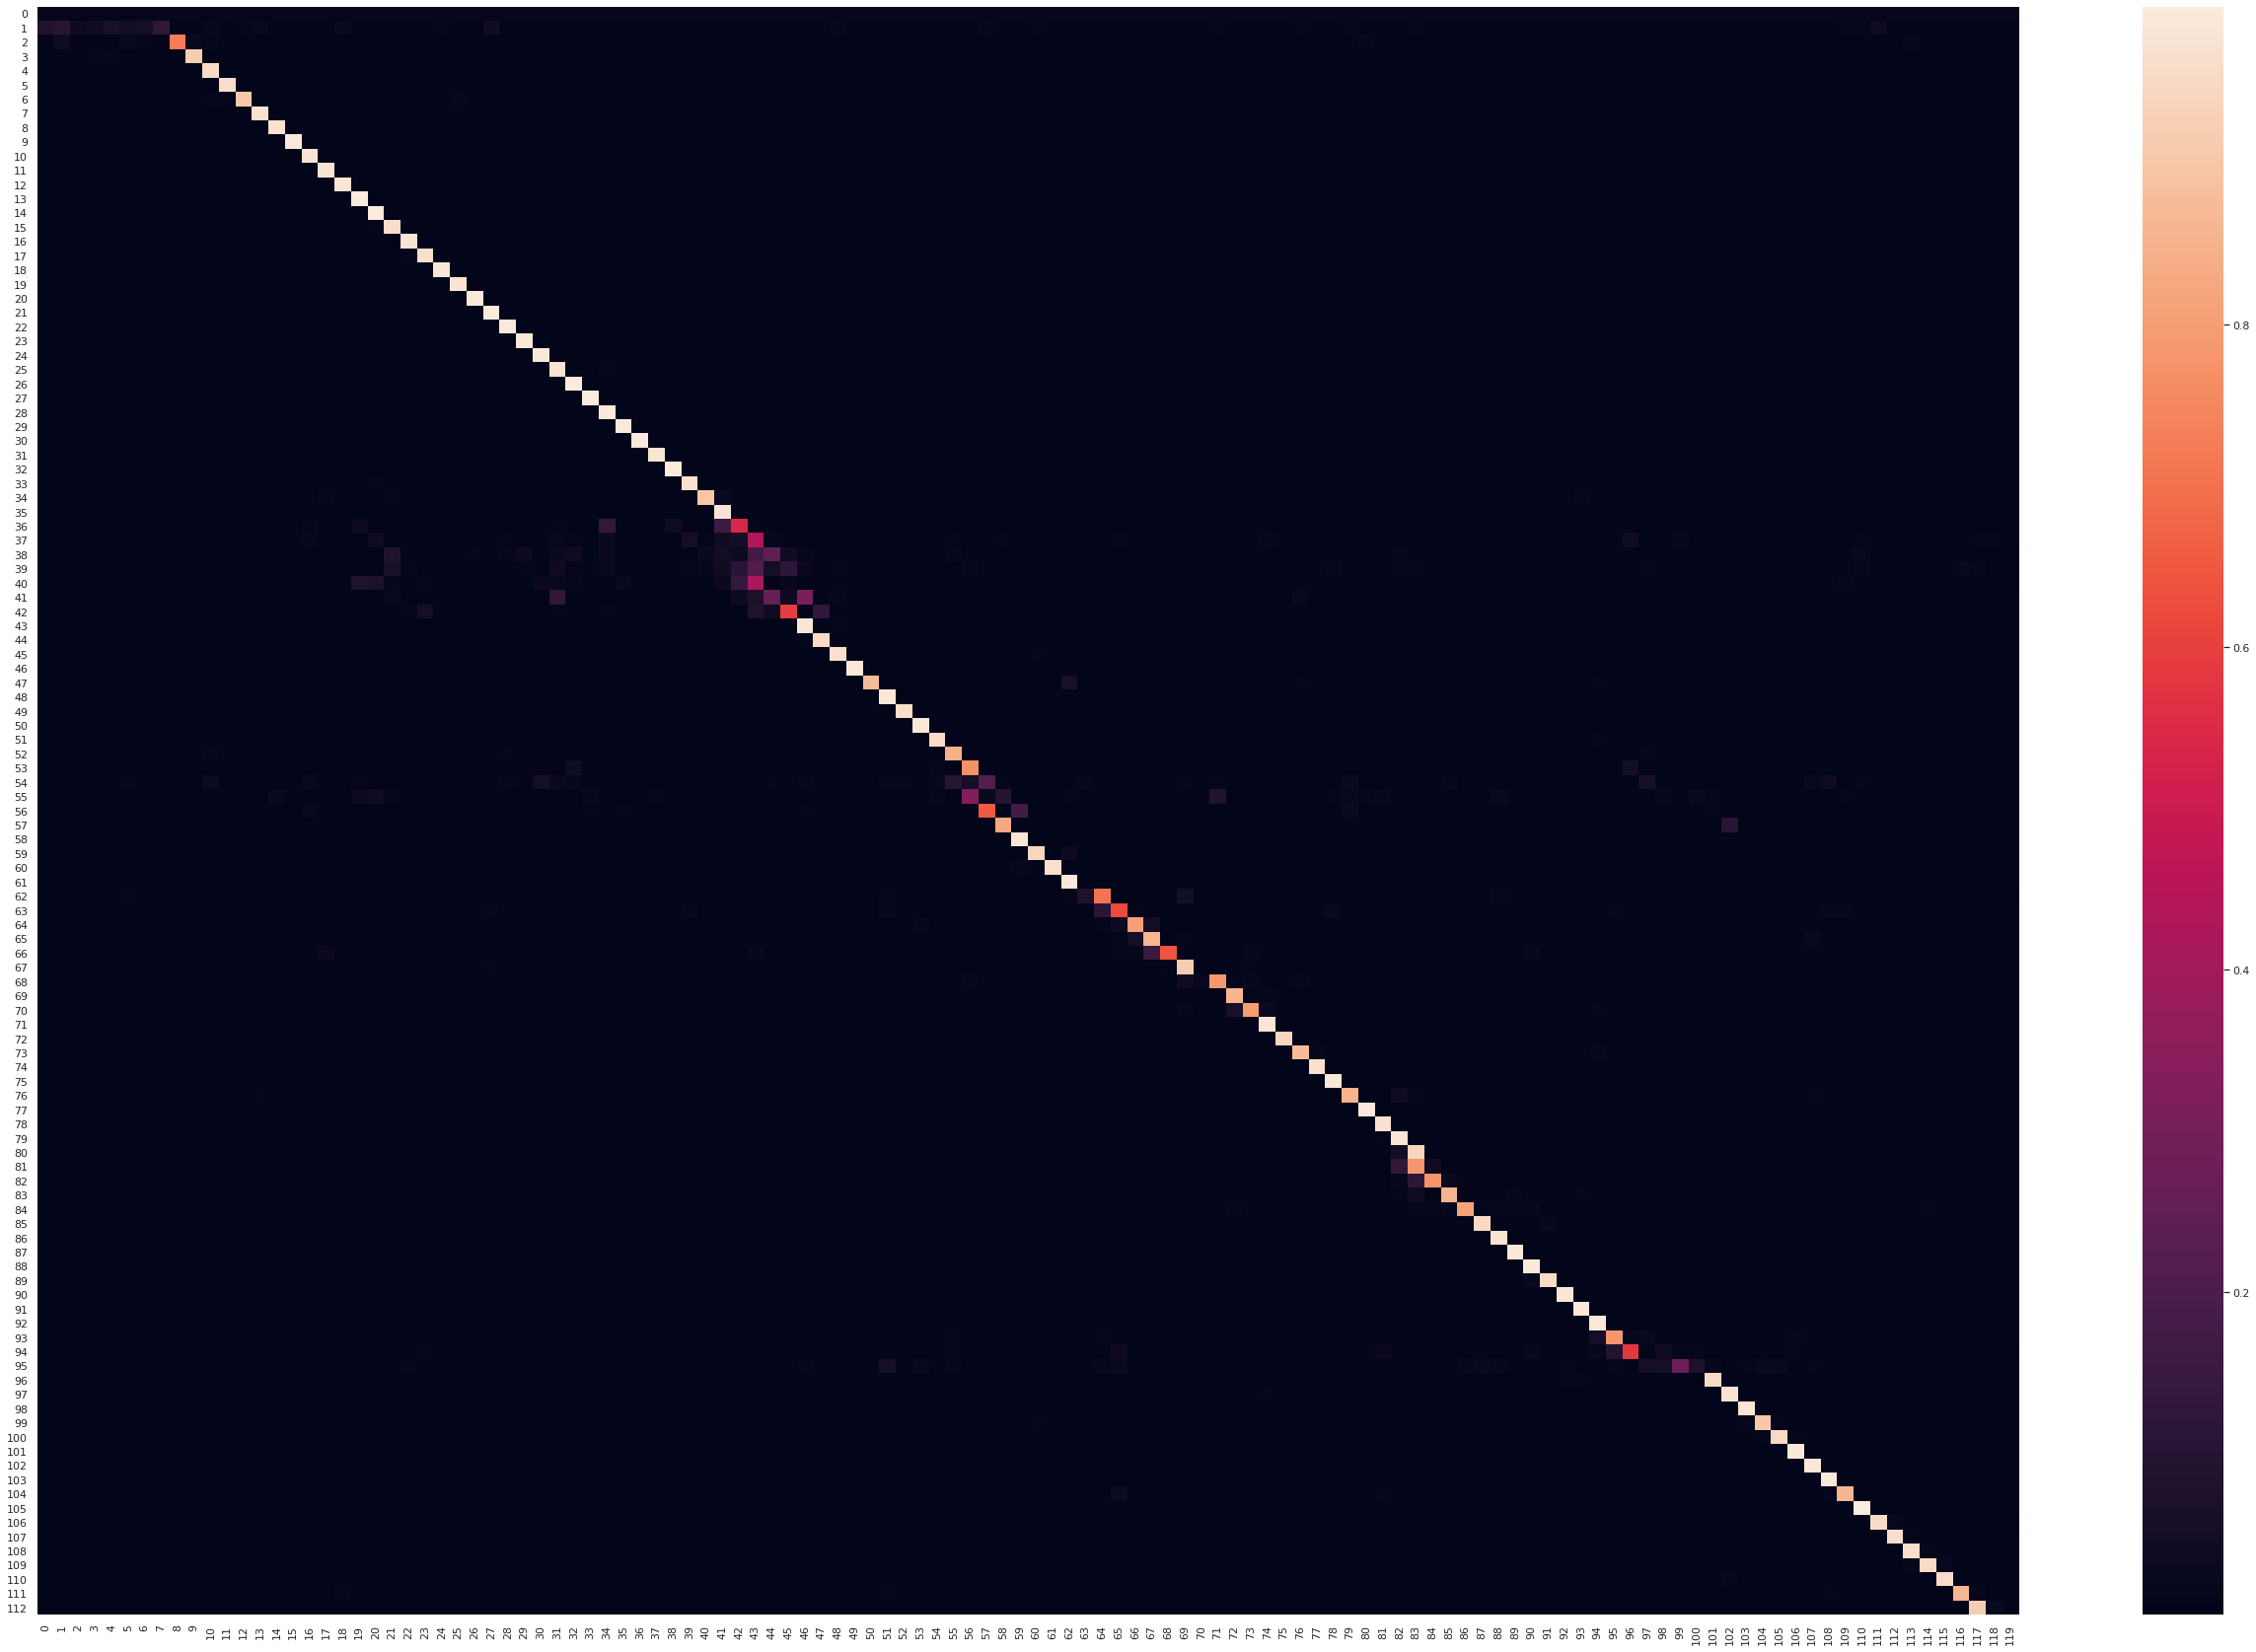

In [29]:
import seaborn as sns

# plot the attention scores of a sequence pair i, j
i = 0
model = 0

seq = fasta_file.column_str(i).replace("$", "-")
print(seq)
attention_scores = bilinear_symmetric_layer(match_embeddings[model][:alignment.length[model]], embedding_cache[i][:fasta_file.seq_lens[i]], a_is_reduced=True, b_is_reduced=True, training=False)
sns.set(rc={'figure.figsize':(45, 30)})
sns.heatmap(attention_scores);

In [27]:
def align_embedding_runner(train_file, ref_file, out_file, config):
    config["allow_user_keys_in_config"] = True
    config["embedding_l2_match"] = 2
    config["len_mul"] = 0.8
    config["use_shared_embedding_insertions"] = True
    config["frozen_insertions"] = True
    config["learning_rate"] = 0.05
    emission_init = [EmbeddingEmissionInitializer() for _ in range(config["num_models"])]
    if config["use_shared_embedding_insertions"]:
        insertion_init = [EmbeddingEmissionInitializer() for _ in range(config["num_models"])]
    else:
        insertion_init = [msa_hmm.initializers.make_default_insertion_init() for _ in range(config["num_models"])]
    config["emitter"] = EmbeddingEmitter(config["embedding_l2_match"], 
                                         0., 
                                         emission_init=emission_init, 
                                         insertion_init=insertion_init,
                                         use_shared_embedding_insertions=config["use_shared_embedding_insertions"],
                                         frozen_insertions=config["frozen_insertions"])
    config["batch_size"] = get_adaptive_batch_size

    result = msa_hmm.align.run_learnMSA(train_file,
                                              out_file,
                                              config, 
                                              model_generator=model_generator,
                                              batch_generator=EmbeddingBatchGenerator(),
                                              ref_filename=ref_file, 
                                              verbose=True,
                                              select_best_for_comparison=True)
    return result

In [ ]:
name = "align_embeddings_attention_C"
Util.run_tests(align_embedding_runner, name, datasets=["homfam"], data_path="../data/")

In [18]:
Util.get_score("align_embeddings_attention_A", "homfam")

0.8076057416821997

In [19]:
Util.get_score("align_embeddings_attention_B", "homfam")

0.7845033657318333

In [29]:
Util.get_score("align_embeddings_attention_C", "homfam")

0.8234429241161184

In [30]:
Util.get_score("align_embeddings_attention_D", "homfam")

0.8289861977284461

In [21]:
!cp -r results/* ../results/

In [31]:
compA = Util.compare("align_embeddings_attention_A", "learnMSA_1.1", "homfam", scale1=True, results_path="../results/")
compA

0
adh             -41.991275
Sulfotransfer   -37.934447
peroxidase      -33.048387
Acetyltransf    -32.978003
aadh            -31.261777
                   ...    
cryst            11.666318
OTCace           13.469435
rhv              38.743204
rvp              46.777537
phc              56.726767
Name: 1, Length: 94, dtype: float64

In [32]:
compB = Util.compare("align_embeddings_attention_B", "learnMSA_1.1", "homfam", scale1=True, results_path="../results/")
compB

0
Sulfotransfer   -50.669311
adh             -50.179195
aat             -36.455258
blmb            -35.886180
peroxidase      -34.500000
                   ...    
kringle          10.973890
DEATH            12.236031
KAS              18.123580
rvp              22.758593
phc              52.730537
Name: 1, Length: 94, dtype: float64

In [34]:
!cp -r results/* ../results/

In [35]:
compC = Util.compare("align_embeddings_attention_C", "learnMSA_1.1", "homfam", scale1=True, results_path="../results/")
compC

0
OTCace         -27.693355
tms            -23.573612
Acetyltransf   -20.966139
adh            -20.434228
aadh           -15.737394
                  ...    
cryst           12.231450
DEATH           12.236031
rhv             15.617192
rvp             46.033288
phc             56.076437
Name: 1, Length: 94, dtype: float64

In [36]:
compD = Util.compare("align_embeddings_attention_D", "learnMSA_1.1", "homfam", scale1=True, results_path="../results/")
compD

0
Acetyltransf   -30.308700
adh            -28.595302
KAS            -18.472521
tRNA-synt_2b   -16.793366
serpin         -11.994435
                  ...    
DEATH           11.922715
cryst           12.231450
rhv             35.009515
rvp             45.897970
phc             52.419510
Name: 1, Length: 94, dtype: float64

In [37]:
import pandas as pd

In [38]:
df = pd.read_csv("../data/homfam/train_stats.csv", sep=",")
df.index = df.family
df["compA"] = compA
df["compB"] = compB
df["compC"] = compC
df["compD"] = compD
df.corr()

,num_seqs,min_l,max_l,avg_l,compA,compB,compC,compD
num_seqs,1.000000,-0.179057,-0.038671,-0.070834,0.123765,-0.028134,0.159055,0.123687
min_l,-0.179057,1.000000,0.030372,0.076250,0.033789,-0.009743,0.051608,0.041695
max_l,-0.038671,0.030372,1.000000,0.780555,-0.082770,-0.215810,-0.120683,0.023219
avg_l,-0.070834,0.076250,0.780555,1.000000,-0.111495,-0.221255,-0.088604,-0.010659
compA,0.123765,0.033789,-0.082770,-0.111495,1.000000,0.761852,0.762396,0.758643
compB,-0.028134,-0.009743,-0.215810,-0.221255,0.761852,1.000000,0.650234,0.520308
compC,0.159055,0.051608,-0.120683,-0.088604,0.762396,0.650234,1.000000,0.806252
compD,0.123687,0.041695,0.023219,-0.010659,0.758643,0.520308,0.806252,1.000000
